# Imports


In [ ]:
!pip install transformers
!pip install sacremoses
!pip install sentencepiece

In [ ]:
#torch and tranformers for model and training
import torch  
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset
from transformers import XLMRobertaTokenizer              
from transformers import XLMRobertaForSequenceClassification
from transformers import AdamW                            
from transformers import get_linear_schedule_with_warmup
import sentencepiece

#sklearn for evaluation
from sklearn import preprocessing                       
from sklearn.metrics import classification_report        
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ParameterGrid         
from sklearn.model_selection import ParameterSampler      
from sklearn.utils.fixes import loguniform

#nlp preprocessing
from nltk import ngrams                                 
from spacy.pipeline import SentenceSegmenter
from spacy.lang.en import English
from spacy.pipeline import Sentencizer
from sacremoses import MosesTokenizer, MosesDetokenizer


#utilities
import pandas as pd
import glob, os
import time
import datetime
import random
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
import pickle

In [ ]:
# show GPU
device = torch.device('cuda')

print('Connected to GPU:', torch.cuda.get_device_name(0))

Connected to GPU: Tesla P100-PCIE-16GB


# Data 

In [ ]:
df_all = pd.read_csv('Relation_Data_LDK2021.csv')

In [ ]:
df_all["dataset"].value_counts()

semeval_2010_train       6590
semeval_2010_test        2263
hyp_train                1617
wordnet_syn_hyp_train     870
reBioInfer                752
hyp_test                  428
ACR_TRAIN                 341
semeval_2007_train        289
wordnet_syn_hyp_test      218
neg_train                 202
semeval_2007_test         172
ACR_TEST                   91
neg_test                   69
labels_ex_train            10
labels_ex_test             10
Name: dataset, dtype: int64

In [ ]:
#select train and test (ignore bioinf)
df_train=df_all.loc[df_all['dataset'].isin(["semeval_2010_train", "semeval_2007_train", "neg_train", "hyp_train", "wordnet_syn_hyp_train", "ACR_TRAIN"])] #, "labels_ex_train"])]
df_test=df_all.loc[df_all['dataset'].isin(["semeval_2010_test", "semeval_2007_test", "neg_test", "hyp_test", "wordnet_syn_hyp_test", "ACR_TEST"])] #, "labels_ex_test"])]

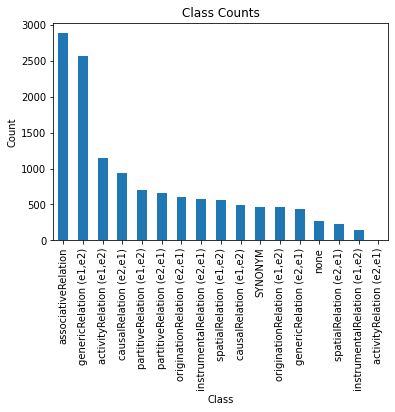

In [ ]:
# print class distribution 
pd.concat([df_train["relation"], df_test["relation"]]).value_counts().plot(kind='bar', title='Class Counts', ylabel="Count", xlabel="Class")

In [ ]:
#input as e1.e2.context; output as label with direction
def prepareInput(df):
  #create new df with one column for input and one for label 
  df_new = pd.DataFrame(columns=["input", "label"])
  #iterate over rows
  for i, row in df.iterrows():
    df_new = df_new.append({
     "input": str(row["e1"])+". "+str(row["e2"])+". "+str(row["raw"]),
     "label": row["relation"]
      }, ignore_index=True)
  return df_new

In [ ]:
df_train = prepareInput(df_train)
df_test = prepareInput(df_test)

In [ ]:
from sklearn import preprocessing                         #for label encoding

labels=list(df_train.label.unique())
print(labels, "\n")

le = preprocessing.LabelEncoder()
le.fit(labels)

df_train["label"]=le.transform(df_train["label"])
df_test["label"]=le.transform(df_test["label"])

labels=le.classes_    #so it has  the same ordering....
print(labels)

['none', 'partitiveRelation (e2,e1)', 'instrumentalRelation (e2,e1)', 'associativeRelation', 'causalRelation (e2,e1)', 'activityRelation (e1,e2)', 'spatialRelation (e1,e2)', 'originationRelation (e2,e1)', 'causalRelation (e1,e2)', 'partitiveRelation (e1,e2)', 'originationRelation (e1,e2)', 'spatialRelation (e2,e1)', 'instrumentalRelation (e1,e2)', 'activityRelation (e2,e1)', 'genericRelation (e1,e2)', 'genericRelation (e2,e1)', 'SYNONYM'] 

['SYNONYM' 'activityRelation (e1,e2)' 'activityRelation (e2,e1)'
 'associativeRelation' 'causalRelation (e1,e2)' 'causalRelation (e2,e1)'
 'genericRelation (e1,e2)' 'genericRelation (e2,e1)'
 'instrumentalRelation (e1,e2)' 'instrumentalRelation (e2,e1)' 'none'
 'originationRelation (e1,e2)' 'originationRelation (e2,e1)'
 'partitiveRelation (e1,e2)' 'partitiveRelation (e2,e1)'
 'spatialRelation (e1,e2)' 'spatialRelation (e2,e1)']


In [ ]:
#additional validation set

from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df_train, test_size=0.2)

**Tokenizer**

In [ ]:
xlmr_tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

In [ ]:
def tokenizer_xlm(data, max_len):
  labels_ = []
  input_ids_ = []
  attn_masks_ = []

  # for each datasample:
  for index, row in data.iterrows():

      sentence = row['input']
      #print(sentence)
     
      # create requiered input, i.e. ids and attention masks
      encoded_dict = xlmr_tokenizer.encode_plus(sentence,
                                                max_length=max_len, 
                                                padding='max_length',
                                                truncation=True, 
                                                return_tensors='pt')

      # add encoded sample to lists
      input_ids_.append(encoded_dict['input_ids'])
      attn_masks_.append(encoded_dict['attention_mask'])
      labels_.append(row['label'])
      
  # Convert each Python list of Tensors into a 2D Tensor matrix.
  input_ids_ = torch.cat(input_ids_, dim=0)
  attn_masks_ = torch.cat(attn_masks_, dim=0)

  # labels to tensor
  labels_ = torch.tensor(labels_)

  print('Encoder finished. {:,} examples.'.format(len(labels_)))
  return input_ids_, attn_masks_, labels_

In [ ]:
#tokenize input for the different training/test sets
max_len=128

input_ids_train, attn_masks_train, labels_train = tokenizer_xlm(df_train, max_len)

input_ids_test, attn_masks_test, labels_test = tokenizer_xlm(df_test, max_len)

input_ids_val, attn_masks_val, labels_val = tokenizer_xlm(df_val, max_len)


Encoder finished. 7,932 examples.
Encoder finished. 3,234 examples.
Encoder finished. 1,984 examples.


In [ ]:
# create datasets
train_dataset = TensorDataset(input_ids_train, attn_masks_train, labels_train)

test_dataset = TensorDataset(input_ids_test, attn_masks_test, labels_test)

val_dataset = TensorDataset(input_ids_val, attn_masks_val, labels_val)


In [ ]:
# create dataloaders
batch_size = 32

train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = batch_size) #random sampling
test_dataloader = DataLoader(test_dataset, sampler = SequentialSampler(test_dataset),batch_size = batch_size ) #sequential sampling
val_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size = batch_size)

#Model

In [ ]:
def create_model(lr, eps, train_dataloader, epochs, device):
  xlmr_model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=len(labels))
  desc = xlmr_model.to(device)
  print('Connected to GPU:', torch.cuda.get_device_name(0))
  optimizer = AdamW(xlmr_model.parameters(),
                  lr = lr,   
                  eps = eps       
                )
  total_steps = len(train_dataloader) * epochs
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,   
                                            num_training_steps = total_steps)
  return xlmr_model, optimizer, scheduler

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))  

In [ ]:
def validate(validation_dataloader, xlmr_model, verbose, print_cm, normalized=False): 
  
  # put model in evaluation mode 
  xlmr_model.eval()

  # Tracking variables 
  total_eval_loss = 0


  predictions, true_labels = [], []

  # Evaluate data for one epoch
  for batch in validation_dataloader:
          
      # Unpack training batch and copy the tensors to the gpu
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)
          
      # no backprop needed
      with torch.no_grad():        

          # forward pass
          output =  xlmr_model(b_input_ids, 
                              token_type_ids=None, 
                              attention_mask=b_input_mask,
                              labels=b_labels)
          loss=output.loss
          logits=output.logits
              
      # add up loss
      total_eval_loss += loss.item()

      # on cpu
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # save preds/true labels
      predictions.append(logits)
      true_labels.append(label_ids)

  # results of the whole validation set
  flat_predictions = np.concatenate(predictions, axis=0)
  flat_true_labels = np.concatenate(true_labels, axis=0)

  # logit to label
  predicted_labels = np.argmax(flat_predictions, axis=1).flatten()

  # print classification report
  if verbose:
    print(classification_report(flat_true_labels, predicted_labels))

  # Calculate the validation accuracy, macro f1, and weighted f1
  val_accuracy = (predicted_labels == flat_true_labels).mean()
  macroF1 = f1_score(flat_true_labels, predicted_labels, average='macro')
  weightedF1 = f1_score(flat_true_labels, predicted_labels, average='weighted')

  # Calculate the average loss over all of the batches.
  avg_val_loss = total_eval_loss / len(validation_dataloader)

  # plot confusion matrix
  if print_cm:
    cm=confusion_matrix(flat_true_labels, predicted_labels, labels=list(range(0, len(labels))))
    if normalized:   
      cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      cm_normalized=np.round(cm_normalized,2)
      fig, ax = plt.subplots(figsize=(8,6))  
      plt.xlabel("Predicted")
      plt.ylabel("True")
      ax = sns.heatmap(cm_normalized, annot=True, linewidths=.5, xticklabels=labels, yticklabels=labels)
      plt.show()
    else:
      fig, ax = plt.subplots(figsize=(8,6))  
      plt.xlabel("Predicted")
      plt.ylabel("True")
      ax = sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, xticklabels=labels, yticklabels=labels)
      plt.show()

  return avg_val_loss, val_accuracy, macroF1, weightedF1
      

In [ ]:
def train_model(epochs, xlmr_model, train_dataloader, validation_dataloader, random_seed, verbose, optimizer, scheduler):

  seed_val = random_seed

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  # mostly contains scores about how the training went for each epoch
  training_stats = []

  # total training time
  total_t0 = time.time()

  print('\033[1m'+"================ Model Training ================"+'\033[0m')

  # For each epoch...
  for epoch_i in range(0, epochs):

      print("")
      print('\033[1m'+'======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs)+'\033[0m')

      t0 = time.time()

      # summed training loss of the epoch
      total_train_loss = 0


      # model is being put into training mode as mechanisms like dropout work differently during train and test time
      xlmr_model.train()

      # iterrate over batches
      for step, batch in enumerate(train_dataloader):

          # unpack training batch at load it to gpu (device)  
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)

          # clear gradients before calculating new ones
          xlmr_model.zero_grad()        

          # forward pass with current batch
          
          #loss, logits = xlmr_model(b_input_ids, 
          #                    token_type_ids=None, 
          #                    attention_mask=b_input_mask, 
          #                    labels=b_labels
          #                    )[:2]

          output=xlmr_model(b_input_ids, 
                              token_type_ids=None, 
                              attention_mask=b_input_mask, 
                              labels=b_labels
                              )
          loss=output.loss
          logits=output.logits

          # add up the loss
          total_train_loss += loss.item()

          # calculate new gradients
          loss.backward()

          # gradient clipping (not bigger than)
          torch.nn.utils.clip_grad_norm_(xlmr_model.parameters(), 1.0)

          # Update the networks weights based on the gradient as well as the optimiziers parameters
          optimizer.step()

          # lr update
          scheduler.step()

      # avg loss over all batches
      avg_train_loss = total_train_loss / len(train_dataloader)            
      
      # training time of this epoch
      training_time = format_time(time.time() - t0)

      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epoch took: {:}".format(training_time))
          
  
      # VALIDATION
      print("evaluate")
      if epoch_i==epochs-1:print_cm=True #Print out cm in final iteration
      else: print_cm=False
      avg_val_loss, val_accuracy, macroF1, weightedF1_no_random = validate(validation_dataloader, xlmr_model, verbose, print_cm)   
       

      print('\033[1m'+ "  Validation Loss All: {0:.2f}".format(avg_val_loss) + '\033[0m')

      training_stats.append(
          {
              'epoch': epoch_i + 1,
              'Training Loss': avg_train_loss,
              'Valid. Loss all': avg_val_loss,
              'Valid. Accur.': val_accuracy,
              'Weigh_F1 all': weightedF1_no_random, 
              'Macro F1 all': macroF1,
              'Training Time': training_time,
          }
      )

  print("\n\nTraining complete!")
  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
  
  return training_stats


In [ ]:
lr=2e-5
eps=1e-8
epochs=9
device = torch.device('cuda')
xlmr_model, optimizer, scheduler = create_model(lr=lr, eps=eps, train_dataloader=train_dataloader, epochs=epochs, device=device)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

Connected to GPU: Tesla T4


================ Model Training ================

======== Epoch 1 / 9 ========

  Average training loss: 1.95
  Training epoch took: 0:02:54
evaluate


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.52      0.66      0.58        67
           1       0.78      0.92      0.85       182
           3       0.64      0.96      0.76       404
           4       0.00      0.00      0.00        80
           5       0.54      0.93      0.68       138
           6       0.89      0.84      0.86       398
           7       0.00      0.00      0.00        72
           8       0.00      0.00      0.00        25
           9       0.75      0.63      0.68        89
          10       0.00      0.00      0.00        41
          11       0.00      0.00      0.00        76
          12       0.52      0.48      0.50        81
          13       0.59      0.76      0.67       109
          14       0.78      0.30      0.43        98
          15       0.48      0.83      0.61        78
          16       1.00      0.04      0.08        46

    accuracy                           0.67      1984
   macro avg       0.47   

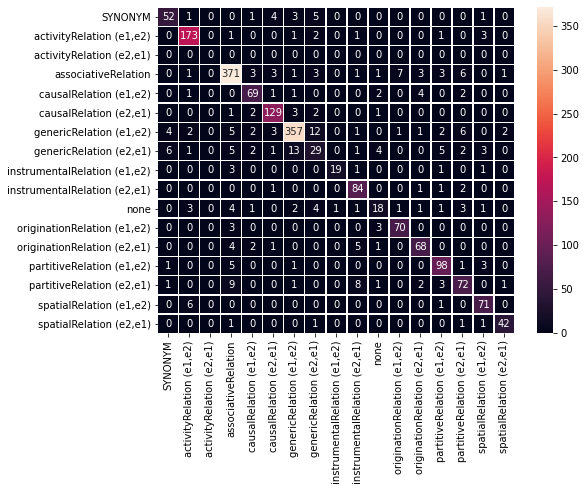

  Validation Loss All: 0.55


Training complete!
Total training took 0:29:16 (h:mm:ss)


In [ ]:
training_stats=train_model(epochs=epochs,
                           xlmr_model=xlmr_model,
                           train_dataloader=train_dataloader,
                           validation_dataloader=val_dataloader,
                           random_seed=42,
                           verbose=True,
                           optimizer=optimizer,
                           scheduler=scheduler)

================ Model Training ================

======== Epoch 1 / 9 ========

  Average training loss: 2.11
  Training epoch took: 0:02:54
evaluate


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.84      0.92      0.88       153
           3       0.55      0.93      0.69       432
           4       0.00      0.00      0.00        73
           5       0.60      0.88      0.72       145
           6       0.00      0.00      0.00         1
           8       0.90      0.84      0.87       403
           9       0.00      0.00      0.00        60
          10       0.00      0.00      0.00        17
          11       0.67      0.09      0.16        86
          12       0.00      0.00      0.00        51
          13       0.00      0.00      0.00        60
          14       0.00      0.00      0.00        89
          17       0.38      0.29      0.33       109
          18       0.33      0.61      0.43        99
          19       0.00      0.00      0.00         1
          21       0.49      0.88      0.63        85
          22       0.00    

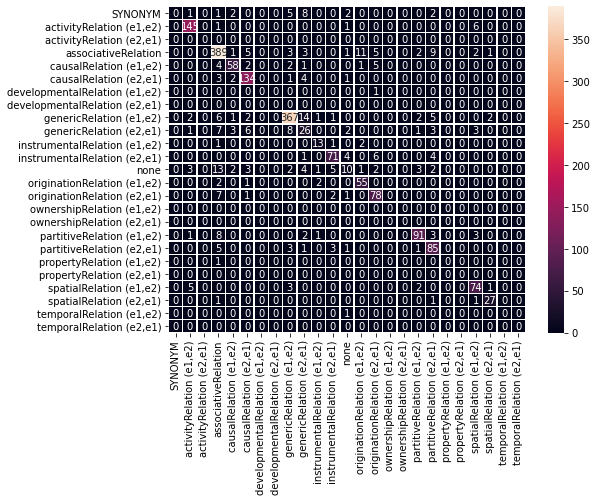

  Validation Loss All: 0.66


Training complete!
Total training took 0:28:53 (h:mm:ss)


In [ ]:
training_stats=train_model(epochs=epochs,
                           xlmr_model=xlmr_model,
                           train_dataloader=train_dataloader,
                           validation_dataloader=val_dataloader,
                           random_seed=42,
                           verbose=True,
                           optimizer=optimizer,
                           scheduler=scheduler)

In [ ]:
#save model
PATH="./saved models/pipeline1803"
xlmr_model.save_pretrained(PATH)

In [ ]:
device = torch.device('cuda')
xlmr_model = XLMRobertaForSequenceClassification.from_pretrained(PATH)

In [ ]:
labels

array(['SYNONYM', 'activityRelation (e1,e2)', 'activityRelation (e2,e1)',
       'associativeRelation', 'causalRelation (e1,e2)',
       'causalRelation (e2,e1)', 'genericRelation (e1,e2)',
       'genericRelation (e2,e1)', 'instrumentalRelation (e1,e2)',
       'instrumentalRelation (e2,e1)', 'none',
       'originationRelation (e1,e2)', 'originationRelation (e2,e1)',
       'partitiveRelation (e1,e2)', 'partitiveRelation (e2,e1)',
       'spatialRelation (e1,e2)', 'spatialRelation (e2,e1)'], dtype='<U28')

# Inference 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.85      0.76      0.80        89
           1       0.93      0.97      0.95       293
           2       0.00      0.00      0.00         2
           3       0.90      0.92      0.91       783
           4       0.90      0.95      0.92       135
           5       0.92      0.91      0.91       222
           6       0.90      0.93      0.92       533
           7       0.46      0.41      0.43        91
           8       0.72      0.68      0.70        34
           9       0.85      0.88      0.86       144
          10       0.69      0.44      0.54        70
          11       0.83      0.89      0.86       116
          12       0.84      0.83      0.83       165
          13       0.90      0.85      0.87       176
          14       0.77      0.77      0.77       168
          15       0.90      0.91      0.91       169
          16       0.90      0.82      0.86        44

    accuracy              

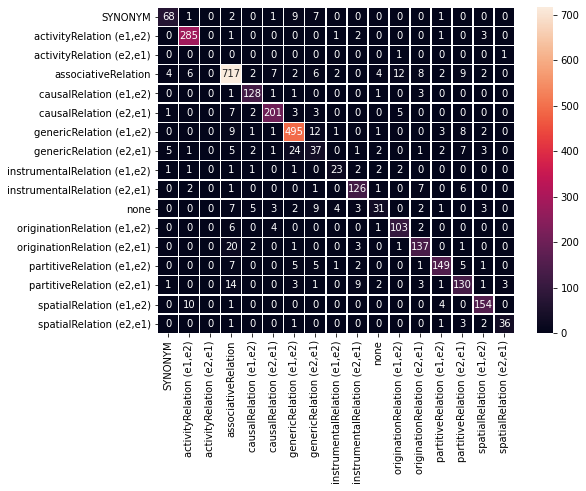

(0.5259877205461118,
 0.8719851576994434,
 0.7670726207867332,
 0.8692259421757473)

In [ ]:
validate(test_dataloader, xlmr_model, verbose=True, print_cm=True, normalized=False)